In [13]:

# Example using argopy in Python
from argopy import DataFetcher
fetcher = DataFetcher().region([45, 80, -80, -65, 0, 1000])  # lon, lat, pressure
argo_ds = fetcher.to_xarray()

SA = gsw.SA_from_SP(argo_ds['PSAL'], argo_ds['PRES'], argo_ds['LONGITUDE'], argo_ds['LATITUDE'])
CT = gsw.CT_from_t(SA, argo_ds['TEMP'], argo_ds['PRES'])
sigma0 = gsw.sigma0(SA, CT)

# Select points with DSW/AABW characteristics
mask = (CT < -1.8) & (SA > 34.5) & (sigma0 > 27.85)
dsw_profiles = argo_ds.where(mask, drop=True)

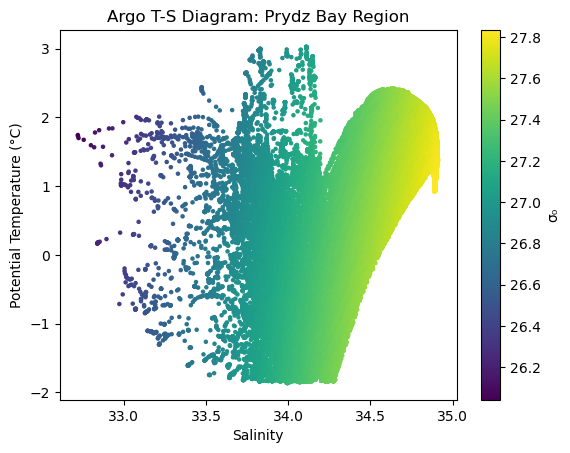

In [3]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(SA, CT, c=sigma0, s=5, cmap='viridis')
plt.xlabel('Salinity')
plt.ylabel('Potential Temperature (°C)')
plt.title('Argo T-S Diagram: Prydz Bay Region')
plt.colorbar(label='σ₀')

In [4]:
# load other packages and the dataset

In [1]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
# sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

from scipy.interpolate import interpn

In [2]:
import netCDF4 as nc

In [3]:
# for plotting
import time
import warnings
warnings.filterwarnings('ignore')
from shapely.ops import unary_union
from shapely import Point

In [4]:
ds = xr.open_dataset("/scratch/mmurakami/WAOM/output/rearranged_output.nc")
weeks = np.loadtxt("weeks_released.txt")
# Open the file
with nc.Dataset('drifter_labels.nc', 'r') as ds1:
    # Check the variable names
    print(ds1.variables.keys())  # likely: 'drifter_label'

    # Read the variable
    drifter_labels = ds1.variables['drifter_label'][:]

print("Loaded drifter labels:", drifter_labels)

# load the longitude and latitude
dg = xr.open_dataset("/scratch/mmurakami/WAOM/output/waom10extend_grd.nc")
ds1 = xr.open_dataset('/scratch/mmurakami/WAOM/output/ocean_avg_0001.nc')

dict_keys(['drifter_label'])
Loaded drifter labels: ['mackenzie' 'mackenzie' 'mackenzie' ... 'other' 'other' 'other']


In [5]:
# create the clusters and check the final distributions
temp = ds['temp'].values
salt = ds['salt'].values
rho = ds['rho'].values
wmt = ds['wmt'].values
depth = ds['depth'].values

In [6]:
# # create the clusters and check the output to see which is which
# # convert the absolute salinity from practical salinity
# # dSA = SA[-1]-SA[0]
# dSA = salt[-1]-salt[0]
# dCT = temp[-1]-temp[0]
# drho_pot = rho[-1]-rho[0]


# df = pd.DataFrame()
# df["dT"] = dCT
# df["dsat"] = dSA
# df["drho"] = drho_pot
# df

In [7]:
# # convert the waom values to gsw values
# # convert depth to sea pressure
# long = 73.5089
# lat = -66.8245
# p = gsw.p_from_z(z=depth,lat=-66.8245)


# # convert the absolute salinity from practical salinity
# SA = gsw.SA_from_SP(salt,p,long,lat)    # absolute salinity from practical salinity

# # convert potential T to conservative T
# CT = gsw.CT_from_pt(SA,temp)   # conservative T from potential T

# # find the potential density from SA, CT, p
# rho_pot = gsw.rho(SA,CT,p) - 1000

# p0 = np.zeros(depth.shape)
# SA0 = gsw.SA_from_SP(salt,p0,long,lat)    # absolute salinity from practical salinity

# # convert potential T to conservative T
# CT0 = gsw.CT_from_pt(SA0,temp)   # conservative T from potential T
# rho_pot0 = gsw.rho(SA0,CT0,p0) - 1000

tmin, tmax, smin, smax sizes=, -3.3 3.63 30.69 38.38


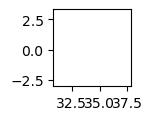

In [8]:
# create the polygons for plotting
# define the polygons for categorizing
# add the polygons and the points
smin = 31 - (0.01 * 31)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38. + (0.01 * 38.)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -3 + (0.1 * -3)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 3.3 + (0.1 * 3.3)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 30
ydim = 30
# Create empty grid of zeros
dens2 = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti1 = np.linspace(-3,3.3,ydim)
si1 = np.linspace(31,38,xdim)
Freez_temp = gsw.CT_freezing(si1,0,0)

Si, Ti = np.meshgrid(si1, ti1, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens2[j,i]=gsw.rho(si1[i],ti1[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens2 - 1000

# convert to practical/potential
long = 73.5089
lat = -66.8245
ti = gsw.pt_from_CT(si1,ti1)
si = gsw.SP_from_SA(si1,0,long,lat)

# create the polygons for the next plot
fig = plt.figure(figsize=(1,1))
ax = fig.add_subplot(1, 1, 1)

# add aabw values
cs = ax.contourf(si, ti, dens2, levels=[27.82,31],colors="black", zorder=1,alpha=0,linestyles='-.')
cl=plt.clabel(cs,fontsize=10,inline=False,fmt="%.2f")
# get the dens2ity vertices
p = cs.collections[0].get_paths()[0]
v = p.vertices
# get the TS vertices
s = np.array([34.5,36,36,34.5,34.5])
t = np.array([-3,-3,0.1,0.1,-3])
b = np.array([[a,b] for a,b in zip(s,t)])
# # find intersection and plot
a = sg.Polygon(v)
b = sg.Polygon(b)
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[0.1,0.1,max(ft)])
c = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(c)
d = a.intersection(b)
aabw = c.intersection(d)

# find the winter water values
cs = ax.contourf(si, ti, dens2, levels=[27.55,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-1.5,-1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
ww = a.intersection(b)

# find the mcdw values
cs = ax.contourf(si, ti, dens2, levels=[27.73,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
ft = Freez_temp
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[1.5,1.5,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
a = sg.Polygon(v)
b = sg.Polygon(b)
mcdw = a.intersection(b)

# --- DSW Polygon ---
# Extract density contour polygon
cs = ax.contourf(si, ti, dens2, levels=[27.82, 31], colors="black", zorder=1, alpha=0, linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
# DSW polygon boundaries
ft_upper = Freez_temp + 0.1
t_lower = -2.5
# Salinity arrays
si_upper = si1
si_lower = si1[::-1]
# Create polygon
poly_si = np.concatenate([si_upper, si_lower])
poly_t = np.concatenate([ft_upper, np.full_like(si_lower, t_lower)])
polygon_pts = np.column_stack([poly_si, poly_t])
c = sg.Polygon(polygon_pts)

# Intersection
dsw_poly = c.intersection(a)
# Ensure it's a Polygon (not MultiPolygon)
if dsw_poly.is_empty:
    dsw = sg.Polygon()
elif dsw_poly.geom_type == 'Polygon':
    dsw = dsw_poly
else:  # MultiPolygon case
    dsw = max(dsw_poly.geoms, key=lambda g: g.area)  # Take largest part

# find the aasw values
cs = ax.contourf(si, ti, dens2, levels=[24,27.73],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.5,34.5,31,31])
sy = np.array([-3,3.5,3.5,-3])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aasw = d.intersection(a)

# --- mSW Polygon ---

# Extract density contour polygon
cs = ax.contourf(si, ti, dens2, levels=[27.82, 31], colors="black", zorder=1, alpha=0, linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)

# mSW polygon boundaries
ft_upper = Freez_temp + 0.1
t_lower = -0.4

# Salinity arrays
si_upper = si1
si_lower = si1[::-1]

# Create polygon
poly_si = np.concatenate([si_upper, si_lower])
poly_t = np.concatenate([ft_upper, np.full_like(si_lower, t_lower)])
polygon_pts = np.column_stack([poly_si, poly_t])
c = sg.Polygon(polygon_pts)

# Intersection
msw_poly = c.intersection(a).difference(dsw)  # Remove DSW region

# Ensure it's a Polygon (not MultiPolygon)
if msw_poly.is_empty:
    msw = sg.Polygon()
elif msw_poly.geom_type == 'Polygon':
    msw = msw_poly
else:  # MultiPolygon case
    msw = max(msw_poly.geoms, key=lambda g: g.area)  # Take largest part

# add ISW values
cs = ax.contourf(si, ti, dens2, levels=[25,27.82],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)
ft = Freez_temp# - 0.05
si2 = si.copy()
si2 = np.append(si2,[max(si2),min(si2),min(si2)])
ft = np.append(ft,[-3,-3,max(ft)])
b = np.array([[a,b] for a,b in zip(si2,ft)])
b = sg.Polygon(b)
isw = b.intersection(a)
#isw = isw.difference(dsw)
isw = isw.difference(aabw)
#ucdw = ucdw.difference(mcdw)
aasw = aasw.difference(ww)
#aasw = aasw.difference(ucdw)

# find the aaiw values
cs = ax.contourf(si, ti, dens2, levels=[27.2,27.4],colors="black", zorder=1,alpha=0,linestyles='-.')
p = cs.collections[0].get_paths()[0]
v = p.vertices
a = sg.Polygon(v)              # first shape in dens2ity
sx = np.array([34.6,34.6,32,32])
sy = np.array([2,3.5,3.5,2])
ss = np.array([[a,b] for a,b in zip(sx,sy)])
b = sg.Polygon(ss)             # second shape in salinity
ft = Freez_temp
ft = np.append(ft,[3.5,3.5])
si2 = si.copy()
si2 = np.append(si2,[35,31])
ta = np.array([[a,b] for a,b in zip(si2,ft)])
c = sg.Polygon(ta)              # third shape in temperature
d = b.intersection(c)
aaiw = d.intersection(a)

In [9]:
T_wdw = -2.05
S_wdw = 34.5
Lf = 334 # kJ/kg
Cp = gsw.cp_t_exact(S_wdw,T_wdw,0)/1000
print(Cp)

Tgade = T_wdw + (Lf/Cp)*(1 - (S_wdw/si))

3.9907110140574806


In [11]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [125]:
from argopy import DataFetcher, IndexFetcher
import gsw
import xarray as xr

# Define bounding boxes for each polynya (lon_min, lon_max, lat_min, lat_max)
polynya_regions = {
    "Darnley":   [55, 72, -74, -62],  # Cape Darnley and adjacent shelf region
    "MacKenzie": [60, 75, -75, -63],  # MacKenzie Bay + upstream/downstream
    "Davis":     [65, 83, -75, -63],  # Davis + broader Prydz Bay region
    "Barrier":   [72, 90, -76, -63]   # Barrier + Amery Ice Shelf region and eastward
}


all_surface_psal = []
all_surface_temp = []

# Loop through each polynya region
for name, bounds in polynya_regions.items():
    lon_min, lon_max, lat_min, lat_max = bounds
    print(f"Checking availability for: {name}")

    # Use IndexFetcher to check for profiles
    try:
        index = DataFetcher().region([lon_min, lon_max, lat_min, lat_max, 10, 300]).to_dataframe()
    except:
        print(f"No ARGO profiles found in {name}. Skipping.")
        continue

    print(f"Profiles found in {name}: {len(index)}. Fetching data...")
    fetcher = DataFetcher().region([lon_min, lon_max, lat_min, lat_max, 0, 10])
    # Select surface layer (0–10 dbar)
    surface_mask = argo_ds['PRES'] <= 100
    surface_psal = argo_ds['PSAL'].where(surface_mask, drop=True)
    surface_temp = argo_ds['TEMP'].where(surface_mask, drop=True)

    all_surface_psal.append(surface_psal)
    all_surface_temp.append(surface_temp)

# Combine all data across regions
if all_surface_psal and all_surface_temp:
    psal_surface_all = xr.concat(all_surface_psal, dim='N_PROF')
    temp_surface_all = xr.concat(all_surface_temp, dim='N_PROF')

    # Convert to numpy arrays if needed
    all_surface_psal = psal_surface_all.values
    all_surface_temp = temp_surface_all.values
    print("Surface salinity and temperature arrays extracted.")
else:
    print("No surface data extracted.")


Checking availability for: Darnley
Profiles found in Darnley: 113453. Fetching data...
Checking availability for: MacKenzie
Profiles found in MacKenzie: 110542. Fetching data...
Checking availability for: Davis
Profiles found in Davis: 130210. Fetching data...
Checking availability for: Barrier
Profiles found in Barrier: 114798. Fetching data...
Surface salinity and temperature arrays extracted.


In [106]:
fetcher = DataFetcher().region([55, 80, -80, -65, 0, 200])  # lon, lat, pressure
argo_ds = fetcher.to_xarray()

all_surface_psal = argo_ds['PSAL'].values
all_surface_temp = argo_ds['TEMP'].values

In [126]:
# original make the 2d histogram
heatmap, xedges, yedges = np.histogram2d(salt[:672].flatten(), temp[:672].flatten(), bins=51)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
C = heatmap.T/len(salt.flatten())

X = np.arange(xedges[0], xedges[-1],(xedges[-1]- xedges[0])/52)   # 0.05 salt
Y = np.arange(yedges[0], yedges[-1],(yedges[-1]- yedges[0])/52)   # 0.1  degree


In [152]:
print(all_surface_psal.shape)
i = 33
print(salt[:i].shape)
a = all_surface_psal.shape
b = salt[:i].shape
print(a[0]*a[1])
print(b[0]*b[1])

(4, 35610)
(33, 4458)
142440
147114


In [153]:
# try again with modified sizes
heatmap, xedges, yedges = np.histogram2d(salt[:i].flatten(), temp[:i].flatten(), bins=[40, 70],range=[[33.4,35], [-2.4, 1.1]])

# Define the extent for the heatmap plot
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Normalize the heatmap
C = heatmap.T / len(salt[:672].flatten())

# Define X and Y arrays with custom bin edges
X = np.arange(xedges[0], xedges[-1], (xedges[-1] - xedges[0]) / 41)  # 0.04
Y = np.arange(yedges[0], yedges[-1], (yedges[-1] - yedges[0]) / 71)  # 0.05

In [154]:
# make an argo heat map similarly
# try again with modified sizes

# argo_ds['PSAL']
# argo_ds['TEMP']
argoheatmap, xedges, yedges = np.histogram2d(all_surface_psal.flatten()+.025, all_surface_temp.flatten(), bins=[40, 70],range=[[33.4,35], [-2.4, 1.1]])

# Define the extent for the heatmap plot
argoextent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Normalize the heatmap
argoC = argoheatmap.T / len(salinity_array.flatten())

# Define X and Y arrays with custom bin edges
argoX = np.arange(xedges[0], xedges[-1], (xedges[-1] - xedges[0]) / 41)  # 0.04
argoY = np.arange(yedges[0], yedges[-1], (yedges[-1] - yedges[0]) / 71)  # 0.05

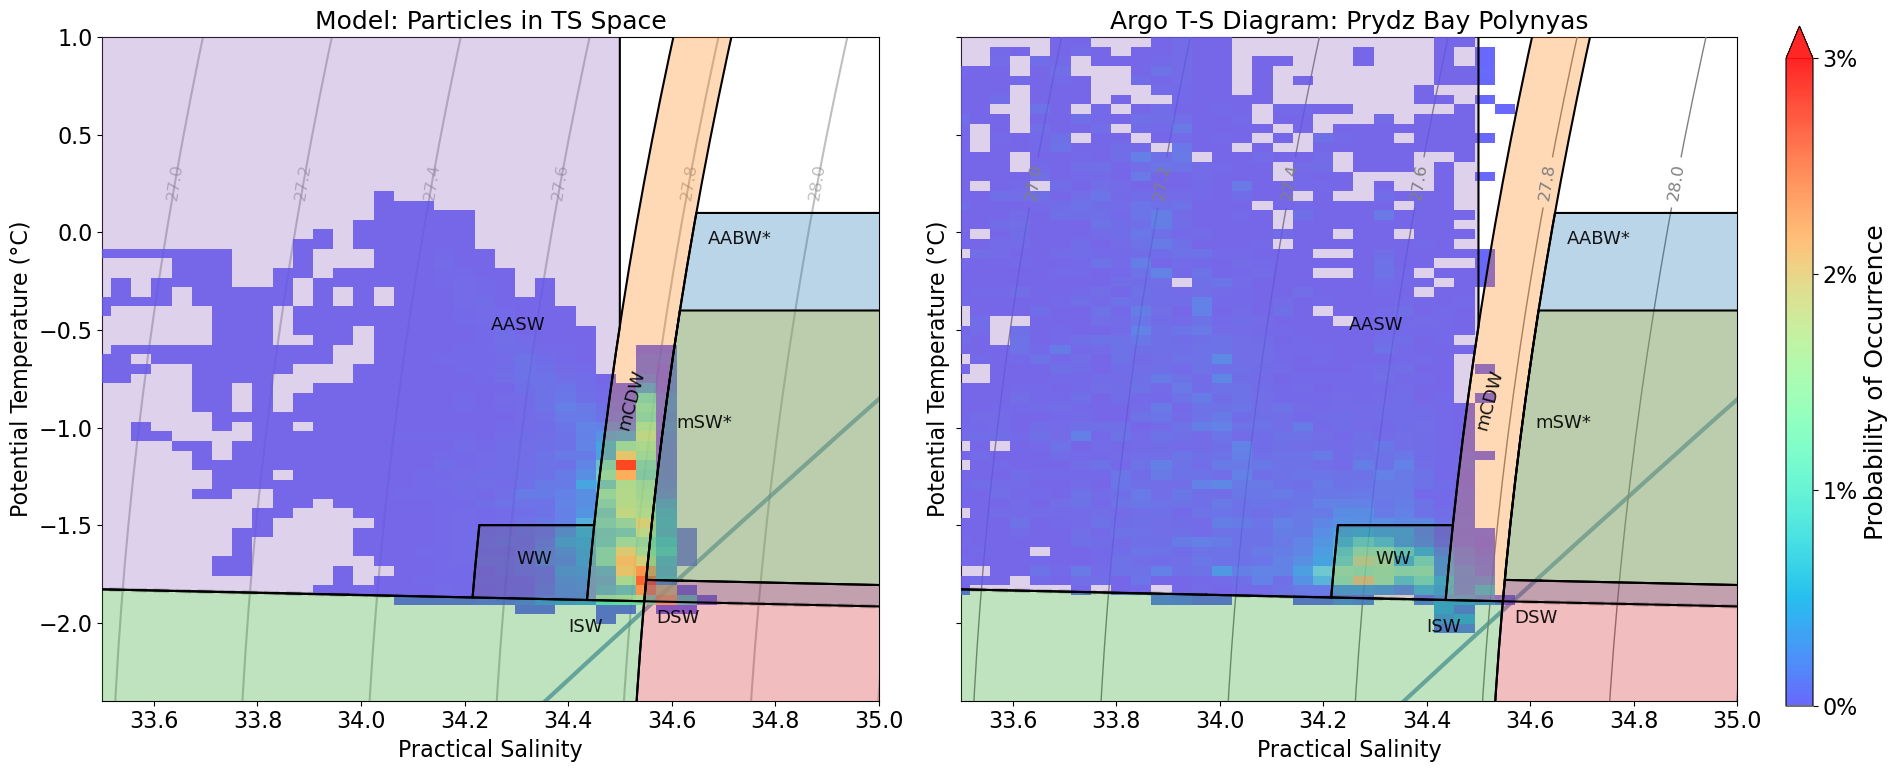

In [144]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 20
})

# Truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Setup figure and axes
fig, (ax1, ax2) = plt.subplots(figsize=(18, 8), ncols=2, gridspec_kw={"width_ratios": [1, 1]}, sharex=True, sharey=True)

# Font settings
plt.rcParams.update({'font.size': 16})
labelsize = 16

# ===== LEFT SUBPLOT: Model =====
ax1.set_xlim(33.5, 35)
ax1.set_ylim(-2.4, 1)
ax1.set_title("Model: Particles in TS Space", fontsize=18)
ax1.set_xlabel('Practical Salinity', fontsize=labelsize)
ax1.set_ylabel('Potential Temperature (°C)', fontsize=labelsize)
ax1.tick_params(labelsize=labelsize)

# Colormap
base_cmap = plt.get_cmap('rainbow')
cmap = truncate_colormap(base_cmap, 0.1, 1.0)
cmap.set_under('white')

# Density contours
cs = ax1.contour(si, ti, dens2, colors="grey", alpha=0.5, levels=np.arange(24, 28.5, 0.2))
ax1.clabel(cs, fontsize=12, inline=False, fmt="%.1f")

# Freezing and Gade lines
ax1.plot(si, Freez_temp, '-', color='silver', linestyle="dashed", label="$T_f$", alpha=0.9, linewidth=3)
ax1.plot(si, Tgade, '-', color='steelblue', label="Gade Line", alpha=0.7, linewidth=3)

# Water mass polygons
for poly, color in zip([aabw, mcdw, isw, dsw, msw, aasw, ww],
                       ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:purple", "tab:brown"]):
    x, y = poly.exterior.xy
    ax1.fill(x, y, alpha=0.3, color=color, zorder=4)
    ax1.plot(x, y, color="black", zorder=5)

# Annotations
labels = {
    "AABW*": (34.67, -0.06), "mCDW": (34.49, -1.0),
    "ISW": (34.4, -2.05), "DSW": (34.57, -2),
    "mSW*": (34.61, -1), "AASW": (34.25, -0.5), "WW": (34.3, -1.7)
}
for label, (x, y) in labels.items():
    if label == "mCDW":
        ax1.text(x, y, label, fontsize=13, alpha=0.9, color="black", rotation=75, zorder=6)
    else:
        ax1.text(x, y, label, fontsize=13, alpha=0.9, color="black", zorder=6)

# Model heatmap
C[C == 0] = np.nan
pcm = ax1.pcolormesh(X, Y, C, cmap=cmap, alpha=0.85, zorder=3, vmax=0.03)

# ===== RIGHT SUBPLOT: Argo =====
ax2.set_title("Argo T-S Diagram: Prydz Bay Polynyas", fontsize=18)
ax2.set_xlabel("Practical Salinity", fontsize=labelsize)
ax2.set_ylabel("Potential Temperature (°C)", fontsize=labelsize)
ax2.tick_params(labelsize=labelsize)

# Polygons (same as left)
for poly, color in zip([aabw, mcdw, isw, dsw, msw, aasw, ww],
                       ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:purple", "tab:brown"]):
    x, y = poly.exterior.xy
    ax2.fill(x, y, alpha=0.3, color=color, zorder=4)
    ax2.plot(x, y, color="black", zorder=5)

ax2.plot(si, Freez_temp, '-', color='silver', linestyle="dashed", label="$T_f$", alpha=0.9, linewidth=3)
ax2.plot(si, Tgade, '-', color='steelblue', label="Gade Line", alpha=0.7, linewidth=3)
# Annotations
for label, (x, y) in labels.items():
    if label == "mCDW":
        ax2.text(x, y, label, fontsize=13, alpha=0.9, color="black", rotation=75, zorder=6)
    else:
        ax2.text(x, y, label, fontsize=13, alpha=0.9, color="black", zorder=6)

# Density contours
cs2 = ax2.contour(si, ti, dens2, levels=np.arange(27, 28.5, 0.2), colors='grey', linewidths=1, zorder=3)
ax2.clabel(cs2, fmt="%.1f", fontsize=12)

# Argo heatmap
argoC[argoC == 0] = np.nan
pcm2 = ax2.pcolormesh(argoX, argoY, argoC, cmap=cmap, alpha=0.85, zorder=3, vmax=0.03)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on right for colorbar

# Full-height colorbar to the right
cbar_ax = fig.add_axes([1, 0.1, 0.015, 0.85])  # [left, bottom, width, height]
cbar = fig.colorbar(pcm2, cax=cbar_ax, extend='max')
cbar.set_label("Probability of Occurrence", fontsize=18)
cbar.set_ticks([0, 0.01, 0.02, 0.03])
cbar.set_ticklabels(['0%', '1%', '2%', '3%'])
cbar.ax.tick_params(labelsize=16)


# Save and show
plt.tight_layout()
# plt.savefig("figure_combined_ts_panels.png", dpi=300)x
plt.show()


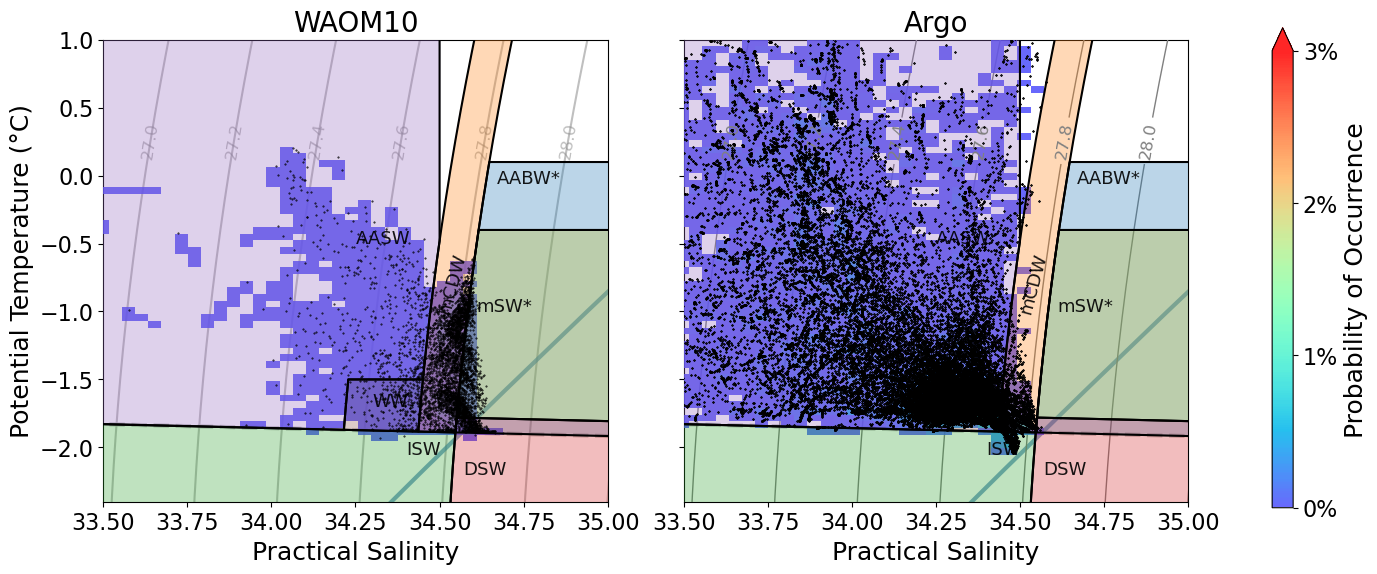

In [157]:
plt.rcParams.update({
    'font.size': 16,
    'axes.labelsize': 18,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'figure.titlesize': 20
})


labels = {
    "AABW*": (34.67, -0.06), "mCDW": (34.49, -1.0),
    "ISW": (34.4, -2.05), "DSW": (34.57, -2.2),
    "mSW*": (34.61, -1), "AASW": (34.25, -0.5), "WW": (34.3, -1.7)
}

# Function to truncate a colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    return LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )

# Setup figure and axes
fig, (ax1, ax2) = plt.subplots(
    ncols=2, figsize=(14, 6),
    sharex=True, sharey=True,
    gridspec_kw={"width_ratios": [1, 1], "wspace": 0.15}
)

# Truncated colormap
base_cmap = plt.get_cmap('rainbow')
cmap = truncate_colormap(base_cmap, 0.1, 1.0)
cmap.set_under('white')

# Common axis limits
ax1.set_xlim(33.5, 35)
ax1.set_ylim(-2.4, 1)

# ==== LEFT: WAOM10 ====
ax1.set_title("WAOM10")
ax1.set_xlabel('Practical Salinity')
ax1.set_ylabel('Potential Temperature (°C)')

# Density contours
cs = ax1.contour(si, ti, dens2, colors="grey", alpha=0.5, levels=np.arange(24, 28.5, 0.2))
ax1.clabel(cs, fontsize=12, inline=False, fmt="%.1f")

# Freezing & Gade lines
ax1.plot(si, Freez_temp, '--', color='silver', label="$T_f$", alpha=0.9, linewidth=3)
ax1.plot(si, Tgade, '-', color='steelblue', label="Gade Line", alpha=0.7, linewidth=3)

# Polygons
for poly, color in zip([aabw, mcdw, isw, dsw, msw, aasw, ww],
                       ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:purple", "tab:brown"]):
    x, y = poly.exterior.xy
    ax1.fill(x, y, alpha=0.3, color=color, zorder=4)
    ax1.plot(x, y, color="black", zorder=5)

# Labels
for label, (x, y) in labels.items():
    rotation = 75 if label == "mCDW" else 0
    ax1.text(x, y, label, fontsize=13, alpha=0.9, color="black", rotation=rotation, zorder=6)

# Model heatmap
C[C == 0] = np.nan
pcm = ax1.pcolormesh(X, Y, C, cmap=cmap, alpha=0.85, zorder=3, vmax=0.03)
ax1.scatter(salt[:1].flatten(),temp[:1].flatten(),s=0.2,color='k',zorder=10)

# ==== RIGHT: ARGO ====
ax2.set_title("Argo")
ax2.set_xlabel('Practical Salinity')
# Share y-axis label from ax1

# Density contours
cs2 = ax2.contour(si, ti, dens2, levels=np.arange(27, 28.5, 0.2), colors='grey', linewidths=1, zorder=3)
ax2.clabel(cs2, fmt="%.1f", fontsize=12)

# Freezing & Gade lines
ax2.plot(si, Freez_temp, '--', color='silver', label="$T_f$", alpha=0.9, linewidth=3)
ax2.plot(si, Tgade, '-', color='steelblue', label="Gade Line", alpha=0.7, linewidth=3)

# Polygons
for poly, color in zip([aabw, mcdw, isw, dsw, msw, aasw, ww],
                       ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:purple", "tab:brown"]):
    x, y = poly.exterior.xy
    ax2.fill(x, y, alpha=0.3, color=color, zorder=4)
    ax2.plot(x, y, color="black", zorder=5)

# Labels
for label, (x, y) in labels.items():
    rotation = 75 if label == "mCDW" else 0
    ax2.text(x, y, label, fontsize=13, alpha=0.9, color="black", rotation=rotation, zorder=6)

# Argo heatmap
argoC[argoC == 0] = np.nan
pcm2 = ax2.pcolormesh(argoX, argoY, argoC, cmap=cmap, alpha=0.85, zorder=3, vmax=0.03)
ax2.scatter(all_surface_psal.flatten()+.025, all_surface_temp.flatten(),s=0.1,color='k',zorder=15)


# Adjust layout
plt.tight_layout(rect=[0, 0, 0.95, 1])

# Add colorbar
cbar_ax = fig.add_axes([0.96, 0.1, 0.015, 0.8])
cbar = fig.colorbar(pcm2, cax=cbar_ax, extend='max')
cbar.set_label("Probability of Occurrence", fontsize=18)
cbar.set_ticks([0, 0.01, 0.02, 0.03])
cbar.set_ticklabels(['0%', '1%', '2%', '3%'])
cbar.ax.tick_params(labelsize=16)

# Show
plt.show()


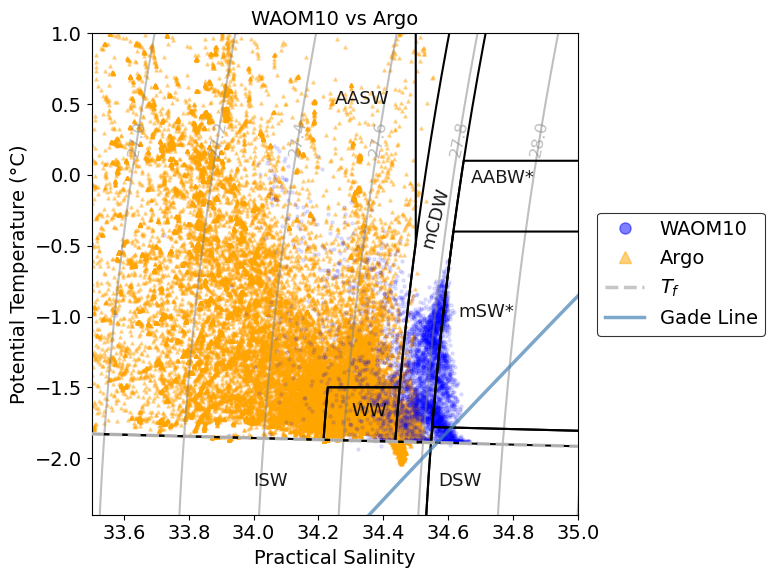

In [199]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 16
})

# Labels for water masses
labels = {
    "AABW*": (34.67, -0.06), "mCDW": (34.51, -0.5),
    "ISW": (34, -2.2), "DSW": (34.57, -2.2),
    "mSW*": (34.63, -1), "AASW": (34.25, 0.5), "WW": (34.3, -1.7)
}

# Setup figure
fig, ax = plt.subplots(figsize=(8, 6))

# Set limits and labels
ax.set_xlim(33.5, 35)
ax.set_ylim(-2.4, 1)
ax.set_xlabel('Practical Salinity')
ax.set_ylabel('Potential Temperature (°C)')
ax.set_title("WAOM10 vs Argo")

# Plot density contours
cs = ax.contour(si, ti, dens2, colors="grey", alpha=0.5, levels=np.arange(24, 28.5, 0.2))
ax.clabel(cs, fontsize=12, inline=False, fmt="%.1f")

# Plot reference lines
ax.plot(si, Freez_temp, '--', color='silver', label="$T_f$", alpha=0.9, linewidth=2.5,zorder=5)
ax.plot(si, Tgade, '-', color='steelblue', label="Gade Line", alpha=0.7, linewidth=2.5,zorder=4)

# Fill water mass polygons
for poly, color in zip([aabw, mcdw, isw, dsw, msw, aasw, ww],
                       ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:olive", "tab:purple", "tab:brown"]):
    x, y = poly.exterior.xy
    #ax.fill(x, y, alpha=0.3, color=color, zorder=1)
    ax.plot(x, y, color="black", zorder=2)

# Add water mass labels
for label, (x, y) in labels.items():
    rotation = 75 if label == "mCDW" else 0
    ax.text(x, y, label, fontsize=13, alpha=0.9, color="black", rotation=rotation, zorder=3)

# === SCATTER POINTS ===
# === SCATTER POINTS ===
# Argo: triangle marker
ax.scatter(all_surface_psal.flatten(), all_surface_temp.flatten(),
           s=5, color='orange', marker='^', alpha=0.1, label="Argo", zorder=1)

# WAOM10: circle marker
ax.scatter(salt[0].flatten(), temp[0].flatten(),
           s=5, color='blue', marker='o', alpha=0.1, label="WAOM10", zorder=1.5)

# === Final touches ===
# === Custom Legend with Proxy Handles ===

legend_handles = [
    Line2D([], [], marker='o', color='blue', linestyle='None',
           markersize=8, alpha=0.5, label='WAOM10'),
    Line2D([], [], marker='^', color='orange', linestyle='None',
           markersize=8, alpha=0.5, label='Argo'),
    Line2D([], [], color='silver', linestyle='--', linewidth=2.5,
           label='$T_f$', alpha=0.9),
    Line2D([], [], color='steelblue', linestyle='-', linewidth=2.5,
           label='Gade Line', alpha=0.7)
]

legend = ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.8)

plt.tight_layout()

plt.savefig("scatter_newfig3.png", dpi=300)

plt.show()


In [184]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
